In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime

from datetime import timedelta, date
import time
import os
import numbers

import warnings
warnings.filterwarnings('ignore')

In [2]:
code_dir = os.path.realpath(os.path.join(os.getcwd(), "../../../filecoin-mecha-twin"))

import sys
sys.path.append(code_dir)

from mechafil.data import get_historical_network_stats, get_sector_expiration_stats, \
    query_starboard_sector_expirations, get_cum_capped_qa_power
from mechafil.power import forecast_power_stats, build_full_power_stats_df
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df, \
    network_time, cum_baseline_reward
from mechafil.supply import forecast_circulating_supply_df

In [3]:
# for time-series prediction - SGT model
#  https://num.pyro.ai/en/stable/tutorials/time_series_forecasting.html 

import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.diagnostics import autocorrelation, hpdi
from numpyro.infer import MCMC, NUTS, Predictive

import jax.numpy as jnp
import jax.random as random
from numpyro.infer import MCMC, NUTS, Predictive

def sgt(y, seasonality, future=0):
    # heuristically, standard derivation of Cauchy prior depends on
    # the max value of data
    cauchy_sd = jnp.max(y) / 150
    # NB: priors' parameters are taken from
    # https://github.com/cbergmeir/Rlgt/blob/master/Rlgt/R/rlgtcontrol.R
    nu = numpyro.sample("nu", dist.Uniform(2, 20))
    powx = numpyro.sample("powx", dist.Uniform(0, 1))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(cauchy_sd))
    offset_sigma = numpyro.sample(
        "offset_sigma", dist.TruncatedCauchy(low=1e-10, loc=1e-10, scale=cauchy_sd)
    )

    coef_trend = numpyro.sample("coef_trend", dist.Cauchy(0, cauchy_sd))
    pow_trend_beta = numpyro.sample("pow_trend_beta", dist.Beta(1, 1))
    # pow_trend takes values from -0.5 to 1
    pow_trend = 1.5 * pow_trend_beta - 0.5
    pow_season = numpyro.sample("pow_season", dist.Beta(1, 1))

    level_sm = numpyro.sample("level_sm", dist.Beta(1, 2))
    s_sm = numpyro.sample("s_sm", dist.Uniform(0, 1))
    init_s = numpyro.sample("init_s", dist.Cauchy(0, y[:seasonality] * 0.3))

    def transition_fn(carry, t):
        level, s, moving_sum = carry
        season = s[0] * level**pow_season
        exp_val = level + coef_trend * level**pow_trend + season
        exp_val = jnp.clip(exp_val, a_min=0)
        # use expected vale when forecasting
        y_t = jnp.where(t >= N, exp_val, y[t])

        moving_sum = (
            moving_sum + y[t] - jnp.where(t >= seasonality, y[t - seasonality], 0.0)
        )
        level_p = jnp.where(t >= seasonality, moving_sum / seasonality, y_t - season)
        level = level_sm * level_p + (1 - level_sm) * level
        level = jnp.clip(level, a_min=0)

        new_s = (s_sm * (y_t - level) / season + (1 - s_sm)) * s[0]
        # repeat s when forecasting
        new_s = jnp.where(t >= N, s[0], new_s)
        s = jnp.concatenate([s[1:], new_s[None]], axis=0)

        omega = sigma * exp_val**powx + offset_sigma
        y_ = numpyro.sample("y", dist.StudentT(nu, exp_val, omega))

        return (level, s, moving_sum), y_

    N = y.shape[0]
    level_init = y[0]
    s_init = jnp.concatenate([init_s[1:], init_s[:1]], axis=0)
    moving_sum = level_init
    with numpyro.handlers.condition(data={"y": y[1:]}):
        _, ys = scan(
            transition_fn, (level_init, s_init, moving_sum), jnp.arange(1, N + future)
        )
    if future > 0:
        numpyro.deterministic("y_forecast", ys[-future:])

## 1. Parameters and other variables

In [4]:
# Data starts in filecoin_daily_stats 2021-03-15
# genesis block was in 2020-08-24
# Main net launch was in 2020-10-15

SIM_START_LAG_DAYS = 10
# set the simulation start date
current_date = datetime.datetime.now().date() - datetime.timedelta(days=SIM_START_LAG_DAYS)
current_day = (current_date - datetime.date(2020, 10, 15)).days

start_date = datetime.date(2021, 3, 15)
start_day = (start_date - datetime.date(2020, 10, 15)).days

# Forecast is one year ahead from today
forecast_lenght = 365*2
end_day = current_day + forecast_lenght
end_date = current_date + datetime.timedelta(days=forecast_lenght)

print(start_date)
print(current_date)
print(end_date)

2021-03-15
2022-11-19
2024-11-18


## 2. Input data

#### Sector scheduled expirations

In [5]:
res = get_sector_expiration_stats(start_date, current_date,end_date)

rb_known_scheduled_expire_vec = res[0]
qa_known_scheduled_expire_vec = res[1]
known_scheduled_pledge_release_full_vec = res[2]

#### Daily network stats

In [6]:
fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)

current_day_stats = fil_stats_df[fil_stats_df["date"] >= current_date].iloc[0]
current_day_stats

circulating_fil               393322677.766723
mined_fil                     238762169.331959
vested_fil                    306589625.967178
locked_fil                    135423984.070128
burnt_fil                      33671752.424059
date                                2022-11-19
total_raw_power_eib                  15.750108
total_qa_power_eib                   18.823026
day_onboarded_rb_power_pib            8.568451
day_onboarded_qa_power_pib            40.70493
day_renewed_qa_power_pib             31.729076
Name: 613, dtype: object

## 1.5 - Use Time-Series prediction methods to power forecasting inputs

In [7]:
num_days_train = 180
quick_run = True
if quick_run:
    num_warmup_mcmc = 500
    num_samples_mcmc = 100
else:
    num_warmup_mcmc = 5000
    num_samples_mcmc = 1000

### 1.5.1 - Forecast rb_onboard_power

In [8]:
x_train = fil_stats_df.index.values[-num_days_train:]
xx_train = fil_stats_df.date[-num_days_train:]
y_train_rb_onboard = jnp.array(fil_stats_df['day_onboarded_rb_power_pib'].values[-num_days_train:])

kernel = NUTS(sgt)
mcmc = MCMC(kernel, num_warmup=num_warmup_mcmc, num_samples=num_samples_mcmc, num_chains=2)
mcmc.run(random.PRNGKey(0), y_train_rb_onboard, seasonality=1000)
mcmc.print_summary()
samples = mcmc.get_samples()

predictive = Predictive(sgt, samples, return_sites=["y_forecast"])
rawbyte_onboard_dist = predictive(random.PRNGKey(1), y_train_rb_onboard, seasonality=1000, future=forecast_lenght)[
    "y_forecast"
]

sample: 100%|███████████████████████████████████████| 600/600 [00:07<00:00, 78.21it/s, 127 steps of size 3.31e-02. acc. prob=0.82]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend     -0.08      0.09     -0.05     -0.22      0.01     57.90      1.01
       init_s[0]      3.37     30.99      0.04    -30.29     22.79    208.30      1.00
       init_s[1]     -1.38      1.05     -1.55     -2.50      0.06    135.14      0.99
       init_s[2]     -1.43      0.87     -1.49     -2.66     -0.25    173.58      0.99
       init_s[3]     -0.59      1.16     -0.69     -2.88      0.88    142.08      1.00
       init_s[4]     -0.17      1.01     -0.19     -1.66      1.49    159.68      1.00
       init_s[5]      0.10      0.98      0.06     -1.50      1.54    108.73      1.01
       init_s[6]     -0.44      1.20     -0.65     -2.15      1.23    107.57      1.01
       init_s[7]      0.16      1.05      0.12     -1.37      1.94     98.61      1.01
       init_s[8]     -0.17      1.23     -0.14     -2.10      1.64    119.61      1.00
       init_s[9]      0.70      1.29      

Text(0, 0.5, 'PiB')

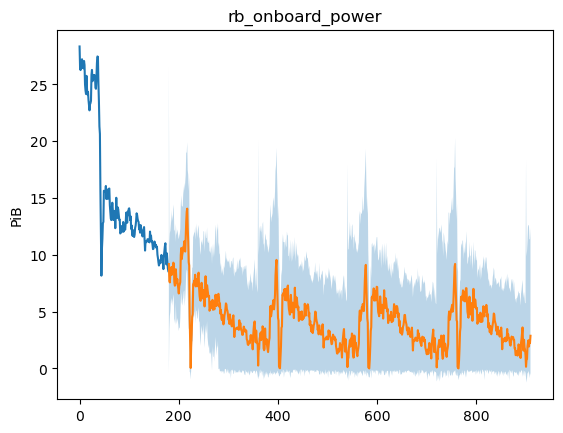

In [9]:
y_pred_rb_onboard_power = jnp.median(rawbyte_onboard_dist, axis=0)
hpd_low, hpd_high = hpdi(rawbyte_onboard_dist)
x_pred = np.arange(len(y_train_rb_onboard), len(y_pred_rb_onboard_power) + len(y_train_rb_onboard))
# fil_stats_df['day_onboarded_rb_power_pib'].plot(); plt.title('Onboarding PiB')
plt.plot(np.arange(len(y_train_rb_onboard)), y_train_rb_onboard)
plt.plot(x_pred, y_pred_rb_onboard_power)
plt.fill_between(x_pred, hpd_low, hpd_high, alpha=0.3)
plt.title('rb_onboard_power')
plt.ylabel('PiB')
# plt.xlim(0,720)

### 1.5.2 - renewal_rate

In [10]:
df_renewal_rate_orig = pd.read_csv('offline_info/Scheduled_Expiration_by_Date_Breakdown_in_PiB.csv')
df_renewal_rate = df_renewal_rate_orig.copy()
df_renewal_rate = df_renewal_rate[df_renewal_rate.stateTime <= str(current_date)]

# y_train_extend = jnp.clip(jnp.array(df_renewal_rate['Extend'].values)[-num_days_train:], a_min=0.001, a_max=None)
y_train_extend = jnp.array(df_renewal_rate['Extend'].values)[-num_days_train:]
if jnp.any(y_train_extend == 0):
    raise ValueError("Starboard data may not be fully populated, as some renewal_extension data is downloaded as 0!\
        An `easy` fix is to change the lag from today when the simulation is started ")

kernel = NUTS(sgt)
mcmc = MCMC(kernel, num_warmup=num_warmup_mcmc, num_samples=num_samples_mcmc, num_chains=2)
mcmc.run(random.PRNGKey(0), y_train_extend, seasonality=1000)
mcmc.print_summary()
samples = mcmc.get_samples()
predictive = Predictive(sgt, samples, return_sites=["y_forecast"])
forecast_extend = predictive(random.PRNGKey(1), y_train_extend, seasonality=1000, future=forecast_lenght)[
    "y_forecast"
]
y_pred_extend = jnp.median(forecast_extend, axis=0)
hpd_low_extend, hpd_high_extend = hpdi(forecast_extend)


# y_train_expire = jnp.clip(jnp.array(df_renewal_rate['Expired'].values)[-num_days_train:], a_min=0.001, a_max=None)
y_train_expire = jnp.array(df_renewal_rate['Expired'].values)[-num_days_train:]
if jnp.any(y_train_expire == 0):
    raise ValueError("Starboard data may not be fully populated, as some renewal_extension data is downloaded as 0!\
        An `easy` fix is to change the lag from today when the simulation is started ")

    
kernel = NUTS(sgt)
mcmc = MCMC(kernel, num_warmup=num_warmup_mcmc, num_samples=num_samples_mcmc, num_chains=2)
mcmc.run(random.PRNGKey(0), y_train_expire, seasonality=1000)
mcmc.print_summary()
samples = mcmc.get_samples()

predictive = Predictive(sgt, samples, return_sites=["y_forecast"])
forecast_expire = predictive(random.PRNGKey(1), y_train_expire, seasonality=1000, future=forecast_lenght)[
    "y_forecast"
]
y_pred_expire = jnp.median(forecast_expire, axis=0)
hpd_low_expire, hpd_high_expire = hpdi(forecast_expire)

sample: 100%|████████████████████████████████████████| 600/600 [00:09<00:00, 60.37it/s, 63 steps of size 4.52e-02. acc. prob=0.73]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend      0.46      0.40      0.34     -0.01      0.95     34.97      1.07
       init_s[0]     -0.55     12.09     -0.22    -20.07     16.57     51.41      1.05
       init_s[1]     -0.81      0.73     -0.81     -1.80      0.53    103.81      0.99
       init_s[2]     -0.47      0.78     -0.45     -1.43      0.64     44.32      1.02
       init_s[3]     -0.47      0.86     -0.45     -1.85      0.95     88.83      1.00
       init_s[4]      2.46      0.75      2.52      1.53      3.87     15.13      1.07
       init_s[5]      5.84      0.84      5.89      4.40      6.90     38.34      1.05
       init_s[6]     27.84      1.09     27.88     26.24     29.55     38.26      1.03
       init_s[7]     -1.07      0.98     -0.97     -2.58      0.34     29.83      1.05
       init_s[8]      0.14      1.03      0.27     -1.41      1.48     41.91      1.04
       init_s[9]      7.92      0.95      

sample: 100%|███████████████████████████████████████| 600/600 [00:12<00:00, 49.68it/s, 255 steps of size 3.79e-02. acc. prob=0.84]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend      0.18      0.14      0.14      0.00      0.39     60.63      1.03
       init_s[0]      1.93     11.68      0.34    -10.74     12.75    138.90      1.00
       init_s[1]     -0.35      0.48     -0.39     -1.08      0.43    209.26      0.99
       init_s[2]      0.26      0.61      0.27     -0.73      1.28    173.03      1.01
       init_s[3]     -1.67      0.66     -1.75     -2.82     -0.64    255.22      1.00
       init_s[4]      1.33      0.67      1.31      0.34      2.60    231.77      1.01
       init_s[5]     -1.22      0.65     -1.28     -2.13      0.01    132.06      1.02
       init_s[6]     13.18      0.71     13.16     12.24     14.51    115.63      1.04
       init_s[7]     -1.93      0.73     -1.95     -3.30     -0.86    161.02      1.01
       init_s[8]     -0.56      0.63     -0.55     -1.71      0.32    134.55      1.02
       init_s[9]     20.31      0.75     2

In [11]:
renewal_dist = forecast_extend / (forecast_extend + forecast_expire)
y_pred_renewal = jnp.median(renewal_dist, axis=0)

Text(0, 0.5, 'Renewal Rate')

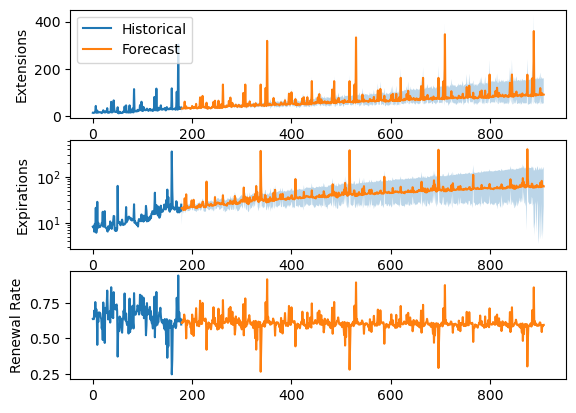

In [12]:
plt.figure()
plt.subplot(3,1,1)
x_pred = np.arange(len(y_train_extend), len(y_pred_extend) + len(y_train_extend))
plt.plot(np.arange(len(y_train_extend)), y_train_extend, label='Historical')
plt.plot(x_pred, y_pred_extend, label='Forecast')
plt.fill_between(x_pred, hpd_low_extend, hpd_high_extend, alpha=0.3)
plt.legend()
plt.ylabel('Extensions')

plt.subplot(3,1,2)
x_pred = np.arange(len(y_train_expire), len(y_pred_expire) + len(y_train_expire))
plt.plot(np.arange(len(y_train_expire)), y_train_expire)
plt.plot(x_pred, y_pred_expire)
plt.fill_between(x_pred, hpd_low_expire, hpd_high_expire, alpha=0.3)
plt.yscale('log')
plt.ylabel('Expirations')

plt.subplot(3,1,3)
plt.plot(np.arange(len(y_train_expire)), y_train_extend/(y_train_extend+y_train_expire))
plt.plot(x_pred, y_pred_renewal)
plt.ylabel('Renewal Rate')

### 1.5.3 - FIL+

In [13]:
# TODO: update to download data directly from starboard
df_deals_orig = pd.read_csv('offline_info/Daily_Active_Deal_TiB_Change_Breakdown.csv')
df_deals = df_deals_orig.copy()
df_deals['deals_onboard'] = df_deals['New Active Deal'] / 1024
df_deals = df_deals[df_deals.stateTime <= str(current_date)]

y_train_deals = jnp.array(df_deals.deals_onboard.values)[-num_days_train:]

print(jnp.argsort(autocorrelation(y_train_deals))[::-1])

kernel = NUTS(sgt)
mcmc = MCMC(kernel, num_warmup=num_warmup_mcmc, num_samples=num_samples_mcmc, num_chains=2)
mcmc.run(random.PRNGKey(0), y_train_deals, seasonality=1000)
mcmc.print_summary()
samples = mcmc.get_samples()

predictive = Predictive(sgt, samples, return_sites=["y_forecast"])
deal_onboard_dist = predictive(random.PRNGKey(1), y_train_deals, seasonality=1000, future=forecast_lenght)[
    "y_forecast"
]

[  0   1   2   3   4  18  16   6   8  17  14   7   5  20  15  13  19  10
  12  21   9  11  22  23  26  28  24  29  25  27  30  31  34  32  33  35
  38  37  41  36  39  42  43  40  44  45  46  47  48  49  51  50  52  53
  55  57  54  56  59  58  60  61  62  63  64  65  67  66  68  69  70  71
  72  73  75  74  77  78  79  76  80  81  82  83  85  84  86  87  88  89
  90  91  92  98  93  94  97  99 100  96  95 101 102 103 104 105 106 157
 158 107 159 108 160 109 115 116 110 111 136 156 112 147 114 117 118 138
 137 113 154 149 148 139 135 146 119 161 153 140 150 145 155 120 144 141
 142 134 151 162 121 143 152 133 132 128 122 123 127 124 126 125 129 131
 130 163 164 165 166 167 177 168 169 170 175 171 176 172 174 173]


sample: 100%|███████████████████████████████████████| 600/600 [00:00<00:00, 618.36it/s, 12 steps of size 9.94e-02. acc. prob=0.66]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend      0.66      0.08      0.69      0.54      0.75      1.11      3.99
       init_s[0]     -0.85      0.89     -0.69     -1.85      0.08      1.01     12.58
       init_s[1]     -1.36      0.11     -1.33     -1.54     -1.23      3.02      1.92
       init_s[2]      0.89      0.88      0.69     -0.05      1.97      1.03      5.86
       init_s[3]     -1.06      1.06     -1.11     -2.16      0.07      1.01     23.05
       init_s[4]      0.62      0.68      0.66     -0.29      1.53      1.07      3.81
       init_s[5]     -0.48      0.47     -0.47     -1.17      0.02      1.04      6.88
       init_s[6]     -0.59      0.61     -0.48     -1.57      0.10      1.11      4.78
       init_s[7]      0.83      0.78      0.86      0.01      1.66      1.01     22.83
       init_s[8]     -0.89      0.92     -0.94     -2.02      0.13      1.03      7.25
       init_s[9]      0.31      0.24      

Text(0.5, 0, 'days')

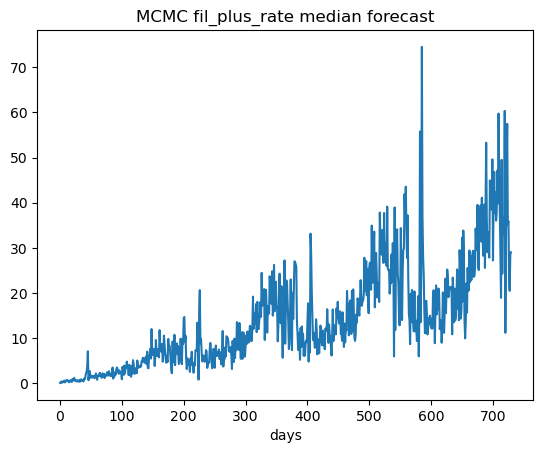

In [14]:
fil_plus_rate_dist = deal_onboard_dist / rawbyte_onboard_dist 
y_fil_plus_rate_pred = jnp.median(fil_plus_rate_dist, axis=0)
plt.plot(y_fil_plus_rate_pred)
plt.title('MCMC fil_plus_rate median forecast'); plt.xlabel('days')

## Choose Power Forecasting Scenario

In [15]:
"""
NOTE: renewal_rate_vec needs to be a vector of the same length as the entire simulation (end_day-start_day),
but rb_onboard_power_pred and fil_plus_rate_pred need to be of length as the forecast amount (end_day-current_day)

TODO: Consider making this a smoother and more intuitive API, right now it is not.
"""

# can be static, mcmc-forecast, or other options that you insert
scenario = '31'  
duration = 360

sector_expirations_df = query_starboard_sector_expirations(start_date, current_date)
historical_renewal_rate = sector_expirations_df['extended_rb'] / (sector_expirations_df['extended_rb'] + sector_expirations_df['expired_rb'] + sector_expirations_df['open_rb'])
historical_renewal_rate = historical_renewal_rate.values

# take median of historical data as baselines
baseline_future_renewal_rate_val = np.median(historical_renewal_rate[-num_days_train:])
baseline_onboarding_rate = np.median(fil_stats_df['day_onboarded_rb_power_pib'].values[-num_days_train:])
fp_pred_len = min(len(y_train_deals), len(y_train_rb_onboard), num_days_train)
historical_filplus_rate = y_train_deals[-fp_pred_len:]/y_train_rb_onboard[-fp_pred_len:]
baseline_filplus_rate = np.median(historical_filplus_rate)

### setup vectors for running defined scenarios
rb_onboard_const_present_value = fil_stats_df['day_onboarded_rb_power_pib'].values[-1]
rb_drop10x_after_upgrade = np.ones(forecast_lenght) * rb_onboard_const_present_value
# find the index where we hit post upgrade
upgrade_idx = datetime.date(2022, 12, 1) - current_date
upgrade_idx = int(upgrade_idx.days)
rb_drop10x_after_upgrade[upgrade_idx:] /= 10

assert forecast_lenght > (12+6+3)*30
rb_drop_exponentially_varying_halving_rates = np.ones(forecast_lenght)*rb_onboard_const_present_value
halving_rates = np.ones(forecast_lenght)
halving_rates[0:365] = 2
ii_hi = int(365+6*30.5); halving_rates[365:ii_hi] = 4
halving_rates[ii_hi:] = 8
for t in range(1,forecast_lenght):
    rb_drop_exponentially_varying_halving_rates[t] =  rb_drop_exponentially_varying_halving_rates[t-1] * np.exp(-t*np.log(halving_rates[t])/365)
max_growth_rate = max(fil_stats_df['day_onboarded_rb_power_pib'])
t_infer = np.arange(forecast_lenght)
x1 = t_infer[0]; y1 = rb_onboard_const_present_value; x2 = forecast_lenght; y2 = max_growth_rate;
b = (y2/y1)**(1./(x2-x1)); a = y1/(b**x1) # solve exponential: https://math.stackexchange.com/a/3276964
rb_increase_exponentially_historically_high_growth = a*np.power(b, t_infer)

renewal_rate_historical_median = np.concatenate([historical_renewal_rate,
                                                 np.repeat(np.median(historical_renewal_rate[-num_days_train:]), 
                                                           (end_day - start_day) - len(historical_renewal_rate))])
renewal_rate_const_0_9 = np.concatenate([historical_renewal_rate,
                                         np.repeat(0.9, (end_day - start_day) - len(historical_renewal_rate))])
renewal_rate_const_0_1 = np.concatenate([historical_renewal_rate,
                                         np.repeat(0.1, (end_day - start_day) - len(historical_renewal_rate))])

fil_plus_rate_current = np.asarray(historical_filplus_rate)[-1]  # b/c we converted to jax
t_infer = np.arange(forecast_lenght)
# fit an exponential between current FIL rate and defined max FIL+ rate
MAX_FILPLUS_RATE = 1; x1 = t_infer[0]; y1 = historical_filplus_rate[-1]; x2 = forecast_lenght; y2 = MAX_FILPLUS_RATE
b = (y2/y1)**(1./(x2-x1)); a = y1/(b**x1) # solve exponential: https://math.stackexchange.com/a/3276964
fil_plus_rate_exp_increasing = a*np.power(b, t_infer)

# fit an exponential between current FIL rate and defined min FIL+ rate
MIN_FILPLUS_RATE = 0.01; x1 = t_infer[0]; y1 = historical_filplus_rate[-1]; x2 = forecast_lenght; y2 = MIN_FILPLUS_RATE
b = (y2/y1)**(1./(x2-x1)); a = y1/(b**x1) # solve exponential: https://math.stackexchange.com/a/3276964
fil_plus_rate_exp_decreasing = a*np.power(b, t_infer)

if scenario == 'static':
    # Renewal rate must now be a vector the length of the simulation
#     future_renewal_rate_val = historical_renewal_rate[-1]
    future_renewal_rate_val = baseline_future_renewal_rate_val
    future_renewal_rate = np.repeat(future_renewal_rate_val, 
                                    (end_day - start_day) - len(historical_renewal_rate))
    renewal_rate_vec_pred = future_renewal_rate  # change this value to test intuitions
    renewal_rate_vec = np.concatenate([historical_renewal_rate,future_renewal_rate])    
    rb_onboard_power_pred = baseline_onboarding_rate
    fil_plus_rate_pred = baseline_filplus_rate
    
    plt_title_str = 'Static[RR=%0.03f,Onboard=%0.02f,FIL+=%0.03f]' % \
        (renewal_rate_vec_pred[-1], rb_onboard_power_pred, fil_plus_rate_pred)
elif scenario == 'mcmc-forecast':
    # setup prediction vectors
    renewal_rate_vec_pred = y_pred_renewal
    renewal_rate_vec = np.concatenate([historical_renewal_rate,renewal_rate_vec_pred])
    rb_onboard_power_pred = y_pred_rb_onboard_power
    fil_plus_rate_pred = y_fil_plus_rate_pred
    
    plt_title_str = 'MCMC[Warmup=%d,Samples=%d]' % (num_warmup_mcmc, num_samples_mcmc)
elif scenario == 'onboarding-drop-static':
    # Renewal rate must now be a vector the length of the simulation
    future_renewal_rate_val = baseline_future_renewal_rate_val
    future_renewal_rate = np.repeat(future_renewal_rate_val, 
                                    (end_day - start_day) - len(historical_renewal_rate))
    renewal_rate_vec_pred = future_renewal_rate  # change this value to test intuitions
    renewal_rate_vec = np.concatenate([historical_renewal_rate,future_renewal_rate])    
    rb_onboard_power_pred = baseline_onboarding_rate*0.1
    fil_plus_rate_pred = baseline_filplus_rate
    
    plt_title_str = 'Onboard-Drop-Static[RR=%0.03f,Onboard=%0.02f,FIL+=%0.03f]' % \
        (renewal_rate_vec_pred[-1], rb_onboard_power_pred, fil_plus_rate_pred)
elif scenario == 'onboarding-drop-linear':
    # Renewal rate must now be a vector the length of the simulation
    future_renewal_rate_val = baseline_future_renewal_rate_val
    future_renewal_rate = np.repeat(future_renewal_rate_val, 
                                    (end_day - start_day) - len(historical_renewal_rate))
    renewal_rate_vec_pred = future_renewal_rate  # change this value to test intuitions
    renewal_rate_vec = np.concatenate([historical_renewal_rate,future_renewal_rate])    
    rb_onboard_power_pred = np.linspace(baseline_onboarding_rate, baseline_onboarding_rate*0.1, forecast_lenght)
    fil_plus_rate_pred = baseline_filplus_rate
    
    plt_title_str = 'Onboard-Drop-Linear[RR=%0.03f,Onboard=(%0.02f,%0.02f),FIL+=%0.03f]' % \
        (renewal_rate_vec_pred[-1], baseline_onboarding_rate, baseline_onboarding_rate*0.1, fil_plus_rate_pred)
elif scenario == 'onboarding-increase-static':
    # Renewal rate must now be a vector the length of the simulation
    future_renewal_rate_val = baseline_future_renewal_rate_val
    future_renewal_rate = np.repeat(future_renewal_rate_val, 
                                    (end_day - start_day) - len(historical_renewal_rate))
    renewal_rate_vec_pred = future_renewal_rate  # change this value to test intuitions
    renewal_rate_vec = np.concatenate([historical_renewal_rate,future_renewal_rate])    
    rb_onboard_power_pred = baseline_onboarding_rate*2
    fil_plus_rate_pred = baseline_filplus_rate
    
    plt_title_str = 'Onboard-Increase-Static[RR=%0.03f,Onboard=%0.02f,FIL+=%0.03f]' % \
        (renewal_rate_vec_pred[-1], rb_onboard_power_pred, fil_plus_rate_pred)
elif scenario == 'onboarding-increase-linear':
    # Renewal rate must now be a vector the length of the simulation
    future_renewal_rate_val = baseline_future_renewal_rate_val
    future_renewal_rate = np.repeat(future_renewal_rate_val, 
                                    (end_day - start_day) - len(historical_renewal_rate))
    renewal_rate_vec_pred = future_renewal_rate  # change this value to test intuitions
    renewal_rate_vec = np.concatenate([historical_renewal_rate,future_renewal_rate])    
    rb_onboard_power_pred = baseline_onboarding_rate*2
    rb_onboard_power_pred = np.linspace(baseline_onboarding_rate, baseline_onboarding_rate*2, forecast_lenght)
    fil_plus_rate_pred = baseline_filplus_rate
    
    plt_title_str = 'Onboard-Increase-Linear[RR=%0.03f,Onboard=(%0.02f,%0.02f),FIL+=%0.03f]' % \
        (renewal_rate_vec_pred[-1], baseline_onboarding_rate, baseline_onboarding_rate*2, fil_plus_rate_pred)
elif scenario == '1':
    rb_onboard_power_pred = rb_onboard_const_present_value
    renewal_rate_vec = renewal_rate_historical_median
    fil_plus_rate_pred = fil_plus_rate_current
    plt_title_str = 'Onboard=Current Value \n RenewalRate=HistoricalMedian \n FIL+=Current Value'
elif scenario == '2':
    rb_onboard_power_pred = rb_onboard_const_present_value
    renewal_rate_vec = renewal_rate_historical_median
    fil_plus_rate_pred = fil_plus_rate_exp_decreasing
    plt_title_str = 'Onboard=Current Value \n RenewalRate=HistoricalMedian \n FIL+=Exponentially Decreasing'
elif scenario == '3':
    rb_onboard_power_pred = rb_onboard_const_present_value
    renewal_rate_vec = renewal_rate_historical_median
    fil_plus_rate_pred = fil_plus_rate_exp_increasing
    plt_title_str = 'Onboard=Current Value \n RenewalRate=HistoricalMedian \n FIL+=Exponentially Increasing'
elif scenario == '4':
    rb_onboard_power_pred = rb_onboard_const_present_value
    renewal_rate_vec = renewal_rate_const_0_9
    fil_plus_rate_pred = fil_plus_rate_current
    plt_title_str = 'Onboard=Current Value \n RenewalRate=0.9 \n FIL+=Current Value'
elif scenario == '5':
    rb_onboard_power_pred = rb_onboard_const_present_value
    renewal_rate_vec = renewal_rate_const_0_9
    fil_plus_rate_pred = fil_plus_rate_exp_decreasing
    plt_title_str = 'Onboard=Current Value \n RenewalRate=0.9 \n FIL+=Exponentially Decreasing'
elif scenario == '6':
    rb_onboard_power_pred = rb_onboard_const_present_value
    renewal_rate_vec = renewal_rate_const_0_9
    fil_plus_rate_pred = fil_plus_rate_exp_increasing
    plt_title_str = 'Onboard=Current Value \n RenewalRate=0.9 \n FIL+=Exponentially Increasing'
elif scenario == '7':
    rb_onboard_power_pred = rb_onboard_const_present_value
    renewal_rate_vec = renewal_rate_const_0_1
    fil_plus_rate_pred = fil_plus_rate_current
    plt_title_str = 'Onboard=Current Value \n RenewalRate=0.1 \n FIL+=Current Value'
elif scenario == '8':
    rb_onboard_power_pred = rb_onboard_const_present_value
    renewal_rate_vec = renewal_rate_const_0_1
    fil_plus_rate_pred = fil_plus_rate_exp_decreasing
    plt_title_str = 'Onboard=Current Value \n RenewalRate=0.1 \n FIL+=Exponentially Decreasing'
elif scenario == '9':
    rb_onboard_power_pred = rb_onboard_const_present_value
    renewal_rate_vec = renewal_rate_const_0_1
    fil_plus_rate_pred = fil_plus_rate_exp_increasing
    plt_title_str = 'Onboard=Current Value \n RenewalRate=0.1 \n FIL+=Exponentially Increasing'

elif scenario == '10':
    rb_onboard_power_pred = rb_drop10x_after_upgrade
    renewal_rate_vec = renewal_rate_historical_median
    fil_plus_rate_pred = fil_plus_rate_current
    plt_title_str = 'Onboard=Drop 10x after Upgrade \n RenewalRate=HistoricalMedian \n FIL+=Current Value'
elif scenario == '11':
    rb_onboard_power_pred = rb_drop10x_after_upgrade
    renewal_rate_vec = renewal_rate_historical_median
    fil_plus_rate_pred = fil_plus_rate_exp_decreasing
    plt_title_str = 'Onboard=Drop 10x after Upgrade \n RenewalRate=HistoricalMedian \n FIL+=Exponentially Decreasing'
elif scenario == '12':
    rb_onboard_power_pred = rb_drop10x_after_upgrade
    renewal_rate_vec = renewal_rate_historical_median
    fil_plus_rate_pred = fil_plus_rate_exp_increasing
    plt_title_str = 'Onboard=Drop 10x after Upgrade \n RenewalRate=HistoricalMedian \n FIL+=Exponentially Increasing'
elif scenario == '13':
    rb_onboard_power_pred = rb_drop10x_after_upgrade
    renewal_rate_vec = renewal_rate_const_0_9
    fil_plus_rate_pred = fil_plus_rate_current
    plt_title_str = 'Onboard=Drop 10x after Upgrade \n RenewalRate=0.9 \n FIL+=Current Value'
elif scenario == '14':
    rb_onboard_power_pred = rb_drop10x_after_upgrade
    renewal_rate_vec = renewal_rate_const_0_9
    fil_plus_rate_pred = fil_plus_rate_exp_decreasing
    plt_title_str = 'Onboard=Drop 10x after Upgrade \n RenewalRate=0.9 \n FIL+=Exponentially Decreasing'
elif scenario == '15':
    rb_onboard_power_pred = rb_drop10x_after_upgrade
    renewal_rate_vec = renewal_rate_const_0_9
    fil_plus_rate_pred = fil_plus_rate_exp_increasing
    plt_title_str = 'Onboard=Drop 10x after Upgrade \n RenewalRate=0.9 \n FIL+=Exponentially Increasing'
elif scenario == '16':
    rb_onboard_power_pred = rb_drop10x_after_upgrade
    renewal_rate_vec = renewal_rate_const_0_1
    fil_plus_rate_pred = fil_plus_rate_current
    plt_title_str = 'Onboard=Drop 10x after Upgrade \n RenewalRate=0.1 \n FIL+=Current Value'
elif scenario == '17':
    rb_onboard_power_pred = rb_drop10x_after_upgrade
    renewal_rate_vec = renewal_rate_const_0_1
    fil_plus_rate_pred = fil_plus_rate_exp_decreasing
    plt_title_str = 'Onboard=Drop 10x after Upgrade \n RenewalRate=0.1 \n FIL+=Exponentially Decreasing'
elif scenario == '18':
    rb_onboard_power_pred = rb_drop10x_after_upgrade
    renewal_rate_vec = renewal_rate_const_0_1
    fil_plus_rate_pred = fil_plus_rate_exp_increasing
    plt_title_str = 'Onboard=Drop 10x after Upgrade \n RenewalRate=0.1 \n FIL+=Exponentially Increasing'
    
elif scenario == '19':
    rb_onboard_power_pred = rb_drop_exponentially_varying_halving_rates
    renewal_rate_vec = renewal_rate_historical_median
    fil_plus_rate_pred = fil_plus_rate_current
    plt_title_str = 'Onboard=Drop Exponentially for Halving Rates[2,4,8]@[1yr,6mo,3mo] \n RenewalRate=HistoricalMedian \n FIL+=Current Value'
elif scenario == '20':
    rb_onboard_power_pred = rb_drop_exponentially_varying_halving_rates
    renewal_rate_vec = renewal_rate_historical_median
    fil_plus_rate_pred = fil_plus_rate_exp_decreasing
    plt_title_str = 'Onboard=Drop Exponentially for Halving Rates[2,4,8]@[1yr,6mo,3mo] \n RenewalRate=HistoricalMedian \n FIL+=Exponentially Decreasing'
elif scenario == '21':
    rb_onboard_power_pred = rb_drop_exponentially_varying_halving_rates
    renewal_rate_vec = renewal_rate_historical_median
    fil_plus_rate_pred = fil_plus_rate_exp_increasing
    plt_title_str = 'Onboard=Drop Exponentially for Halving Rates[2,4,8]@[1yr,6mo,3mo] \n RenewalRate=HistoricalMedian \n FIL+=Exponentially Increasing'
elif scenario == '22':
    rb_onboard_power_pred = rb_drop_exponentially_varying_halving_rates
    renewal_rate_vec = renewal_rate_const_0_9
    fil_plus_rate_pred = fil_plus_rate_current
    plt_title_str = 'Onboard=Drop Exponentially for Halving Rates[2,4,8]@[1yr,6mo,3mo] \n RenewalRate=0.9 \n FIL+=Current Value'
elif scenario == '23':
    rb_onboard_power_pred = rb_drop_exponentially_varying_halving_rates
    renewal_rate_vec = renewal_rate_const_0_9
    fil_plus_rate_pred = fil_plus_rate_exp_decreasing
    plt_title_str = 'Onboard=Drop Exponentially for Halving Rates[2,4,8]@[1yr,6mo,3mo] \n RenewalRate=0.9 \n FIL+=Exponentially Decreasing'
elif scenario == '24':
    rb_onboard_power_pred = rb_drop_exponentially_varying_halving_rates
    renewal_rate_vec = renewal_rate_const_0_9
    fil_plus_rate_pred = fil_plus_rate_exp_increasing
    plt_title_str = 'Onboard=Drop Exponentially for Halving Rates[2,4,8]@[1yr,6mo,3mo] \n RenewalRate=0.9 \n FIL+=Exponentially Increasing'
elif scenario == '25':
    rb_onboard_power_pred = rb_drop_exponentially_varying_halving_rates
    renewal_rate_vec = renewal_rate_const_0_1
    fil_plus_rate_pred = fil_plus_rate_current
    plt_title_str = 'Onboard=Drop Exponentially for Halving Rates[2,4,8]@[1yr,6mo,3mo] \n RenewalRate=0.1 \n FIL+=Current Value'
    plt_title_str = 'Onboard=Drop Exponentially for Halving Rates[2,4,8]@[1yr,6mo,3mo] \n RenewalRate=0.1'
elif scenario == '26':
    rb_onboard_power_pred = rb_drop_exponentially_varying_halving_rates
    renewal_rate_vec = renewal_rate_const_0_1
    fil_plus_rate_pred = fil_plus_rate_exp_decreasing
    plt_title_str = 'Onboard=Drop Exponentially for Halving Rates[2,4,8]@[1yr,6mo,3mo] \n RenewalRate=0.1 \n FIL+=Exponentially Decreasing'
elif scenario == '27':
    rb_onboard_power_pred = rb_drop_exponentially_varying_halving_rates
    renewal_rate_vec = renewal_rate_const_0_1
    fil_plus_rate_pred = fil_plus_rate_exp_increasing
    plt_title_str = 'Onboard=Drop Exponentially for Halving Rates[2,4,8]@[1yr,6mo,3mo] \n RenewalRate=0.1 \n FIL+=Exponentially Increasing'

elif scenario == '28':
    rb_onboard_power_pred = rb_increase_exponentially_historically_high_growth
    renewal_rate_vec = renewal_rate_historical_median
    fil_plus_rate_pred = fil_plus_rate_current
    plt_title_str = 'Onboard=Increase Exponentially to Historical High \n RenewalRate=HistoricalMedian \n FIL+=Current Value'
elif scenario == '29':
    rb_onboard_power_pred = rb_increase_exponentially_historically_high_growth
    renewal_rate_vec = renewal_rate_historical_median
    fil_plus_rate_pred = fil_plus_rate_exp_decreasing
    plt_title_str = 'Onboard=Increase Exponentially to Historical High \n RenewalRate=HistoricalMedian \n FIL+=Exponentially Decreasing'
elif scenario == '30':
    rb_onboard_power_pred = rb_increase_exponentially_historically_high_growth
    renewal_rate_vec = renewal_rate_historical_median
    fil_plus_rate_pred = fil_plus_rate_exp_increasing
    plt_title_str = 'Onboard=Increase Exponentially to Historical High \n RenewalRate=HistoricalMedian \n FIL+=Exponentially Increasing'
elif scenario == '31':
    rb_onboard_power_pred = rb_increase_exponentially_historically_high_growth
    renewal_rate_vec = renewal_rate_const_0_9
    fil_plus_rate_pred = fil_plus_rate_current
#     plt_title_str = 'Onboard=Increase Exponentially to Historical High \n RenewalRate=0.9 \n FIL+=Current Value'
    plt_title_str = 'Onboard=Increase Exponentially to Historical High \n RenewalRate=0.9'
elif scenario == '32':
    rb_onboard_power_pred = rb_increase_exponentially_historically_high_growth
    renewal_rate_vec = renewal_rate_const_0_9
    fil_plus_rate_pred = fil_plus_rate_exp_decreasing
    plt_title_str = 'Onboard=Increase Exponentially to Historical High \n RenewalRate=0.9 \n FIL+=Exponentially Decreasing'
elif scenario == '33':
    rb_onboard_power_pred = rb_increase_exponentially_historically_high_growth
    renewal_rate_vec = renewal_rate_const_0_9
    fil_plus_rate_pred = fil_plus_rate_exp_increasing
    plt_title_str = 'Onboard=Increase Exponentially to Historical High \n RenewalRate=0.9 \n FIL+=Exponentially Increasing'
elif scenario == '34':
    rb_onboard_power_pred = rb_increase_exponentially_historically_high_growth
    renewal_rate_vec = renewal_rate_const_0_1
    fil_plus_rate_pred = fil_plus_rate_current
    plt_title_str = 'Onboard=Increase Exponentially to Historical High \n RenewalRate=0.1 \n FIL+=Current Value'
elif scenario == '35':
    rb_onboard_power_pred = rb_increase_exponentially_historically_high_growth
    renewal_rate_vec = renewal_rate_const_0_1
    fil_plus_rate_pred = fil_plus_rate_exp_decreasing
    plt_title_str = 'Onboard=Increase Exponentially to Historical High \n RenewalRate=0.1 \n FIL+=Exponentially Decreasing'
elif scenario == '36':
    rb_onboard_power_pred = rb_increase_exponentially_historically_high_growth
    renewal_rate_vec = renewal_rate_const_0_1
    fil_plus_rate_pred = fil_plus_rate_exp_increasing
    plt_title_str = 'Onboard=Increase Exponentially to Historical High \n RenewalRate=0.1 \n FIL+=Exponentially Increasing'

    
else:
    raise Exception("Bad scenario specified!")

## 2. Forecast power stats

In [16]:
rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0

rb_power_df, qa_power_df = forecast_power_stats(
    rb_power_zero,
    qa_power_zero,
    rb_onboard_power_pred,
    rb_known_scheduled_expire_vec,
    qa_known_scheduled_expire_vec,
    renewal_rate_vec[-int(forecast_lenght):],
    fil_plus_rate_pred,
    duration,
    forecast_lenght
)
rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0

In [17]:
power_df = build_full_power_stats_df(
    fil_stats_df,
    rb_power_df,
    qa_power_df,
    start_date,
    current_date,
    end_date,
)

## 3. Forecast Vesting

In [18]:
vest_df = compute_vesting_trajectory_df(start_date, end_date)

## 4. Forecast minting stats and baseline

In [19]:
rb_total_power_eib = power_df["total_raw_power_eib"].values
qa_total_power_eib = power_df["total_qa_power_eib"].values
qa_day_onboarded_power_pib = power_df["day_onboarded_qa_power_pib"].values
qa_day_renewed_power_pib = power_df["day_renewed_qa_power_pib"].values

mint_df = compute_minting_trajectory_df(
    start_date,
    end_date,
    rb_total_power_eib,
    qa_total_power_eib,
    qa_day_onboarded_power_pib,
    qa_day_renewed_power_pib,
)

## 5. Baseline crossing

In [20]:
assert len(power_df) == len(mint_df)
assert power_df.iloc[0]['date'] == mint_df.iloc[0]['date']

# BASELINE_B0 = 2.88888888 # should be this
BASELINE_B0 = 2.7636 # this value is required to match sentinel
BASELINE_R = np.log(2) / (2880*365) # 1_051_200 in eopchs
EPOCH_PER_DAY = 2880
def baseline_storage(epoch: float)->float:
    return BASELINE_B0 * np.exp(BASELINE_R * epoch)

baseline_df = pd.DataFrame({
    'date': mint_df.date,
    'baseline_storage': baseline_storage(mint_df.days * EPOCH_PER_DAY)}
)

rb_crossing_above = power_df[power_df["total_raw_power_eib"] > baseline_df['baseline_storage']]["date"].iloc[0]
power_df_afterfirstcrossing = power_df[power_df['date'] > pd.to_datetime(rb_crossing_above)]
baseline_df_afterfirstcrossing = baseline_df[baseline_df['date'] > pd.to_datetime(rb_crossing_above)]
rb_crossing_below = power_df_afterfirstcrossing[power_df_afterfirstcrossing["total_raw_power_eib"] < baseline_df_afterfirstcrossing["baseline_storage"]]["date"].iloc[0]
qa_crossing_below_df = power_df_afterfirstcrossing[power_df_afterfirstcrossing["total_qa_power_eib"] < baseline_df_afterfirstcrossing["baseline_storage"]]
if len(qa_crossing_below_df) > 0:
    qa_crossing_below = qa_crossing_below_df["date"].iloc[0]
else:
    qa_crossing_below = None

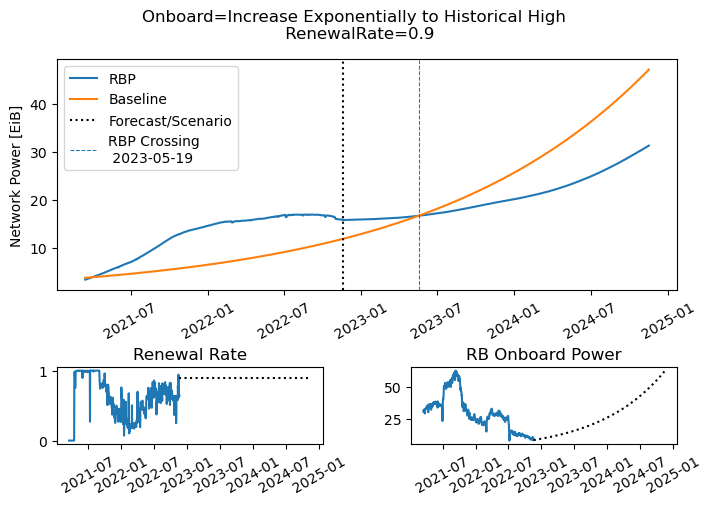

In [21]:
plt.figure(figsize=(8,5))
grid = plt.GridSpec(3, 4, wspace=1, hspace=1)

plt.subplot(grid[0:2, 0:4])
plt.plot(power_df.date, power_df.total_raw_power_eib, label='RBP')
# plt.plot(power_df.date, power_df.total_qa_power_eib, label='QAP')
plt.plot(mint_df.date, baseline_storage(mint_df.days * EPOCH_PER_DAY), label='Baseline')
plt.axvline(current_date, color='k', linestyle=':', label='Forecast/Scenario')
plt.axvline(rb_crossing_below, linestyle='--', lw=0.75, label='RBP Crossing \n %s' % (rb_crossing_below,))
plt.xticks(rotation=30)
plt.legend(loc='upper left')
plt.ylabel('Network Power [EiB]')

t_cur = power_df[power_df['date'] >= current_date]
plt.subplot(grid[2,0:2])
plt.plot(fil_stats_df.date, historical_renewal_rate)
plt.plot(t_cur.date, renewal_rate_vec[len(historical_renewal_rate):], color='k', linestyle=':')
plt.xticks(rotation=30)
plt.title('Renewal Rate')

plt.subplot(grid[2,2:4])
plt.plot(fil_stats_df.date, fil_stats_df['day_onboarded_rb_power_pib'])
if isinstance(rb_onboard_power_pred, numbers.Number):
    plt.plot(t_cur.date, np.ones(forecast_lenght)*rb_onboard_power_pred, color='k', linestyle=':')
else:
    plt.plot(t_cur.date, rb_onboard_power_pred, color='k', linestyle=':')
plt.title('RB Onboard Power')
plt.xticks(rotation=30)

plt.suptitle(plt_title_str)
plt.tight_layout()